In [5]:
import sys

sys.path.append('../')

import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem import rdchem
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from rdkit.Chem.Descriptors import ExactMolWt
import umap

import numpy as np
from sklearn.decomposition import PCA
from ast import literal_eval
from dataloader import DreamLoader

import matplotlib as mpl
from collections import Counter
mpl.rcParams['figure.facecolor'] = 'white'

In [6]:
def get_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
        if tuple(sorted(elements)) == ('C', 'H', 'O'):
            print(smiles)
        return tuple(sorted(elements))
    else:
        return []
    
def is_chiral(mol):
    chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
    return len(chiral_centers) > 0

def check_cis_trans_isomerism(mol):
    has_cis_trans = False
    for bond in mol.GetBonds():
        # Check if the bond is a double bond
        if bond.GetBondType() == rdchem.BondType.DOUBLE:
            # Check if the double bond has stereochemistry information
            stereo = bond.GetStereo()
            if stereo in [rdchem.BondStereo.STEREOZ, rdchem.BondStereo.STEREOE, rdchem.BondStereo.STEREOCIS, rdchem.BondStereo.STEREOTRANS]:
                has_cis_trans = True
                break

    return has_cis_trans

In [7]:
file_df = pd.read_csv('file_cleaning_features.csv')
file_df

,dataset,unclean,label_columns,task,new_label_columns,task_dim,n_datapoints,features,validate
0,arctander_1960,arctander_1960/arctander_1960_unclean.csv,"['acid', 'aldehydic', 'almond', 'ambre', 'anim...",multilabel,"['aldehydic', 'almond', 'ambre', 'animal', 'an...",58,2417,['IsomericSMILES'],True
1,flavornet,flavornet/flavornet_unclean.csv,"['acid', 'alcohol', 'alkaline', 'alkane', 'alm...",multilabel,"['alkane', 'citrus', 'earth', 'fat', 'flower',...",14,411,['IsomericSMILES'],True
2,ifra_2019,ifra_2019/ifra_2019_unclean.csv,"['Acidic', 'Aldehydic', 'Almond', 'Amber', 'An...",multilabel,"['aldehydic', 'amber', 'anisic', 'apple', 'bal...",32,1026,['IsomericSMILES'],True
3,sigma_2014,sigma_2014/sigma_2014_unclean.csv,"['potato', 'marigold', 'anise', 'herba-', 'car...",multilabel,"['anise', 'rose', 'coffee', 'creamy', 'herbace...",41,806,['IsomericSMILES'],True
4,keller_2016,keller_2016/keller_2016_unclean_processed.csv,"['Acid_mean', 'Ammonia_mean', 'Bakery_mean', '...",regression,"['Acid_mean', 'Ammonia_mean', 'Bakery_mean', '...",132,475,['IsomericSMILES'],True
5,abraham_2012,abraham_2012/abraham_2012_unclean.csv,['Log (1/ODT)'],regression,['Log (1/ODT)'],1,266,['IsomericSMILES'],True
6,mayhew_2022,mayhew_2022/mayhew_2022_unclean.csv,['Odor'],binary,['odor'],1,1765,['IsomericSMILES'],True
7,leffingwell,leffingwell/leffingwell_unclean.csv,"['alcoholic', 'aldehydic', 'alliaceous', 'almo...",multilabel,"['alcoholic', 'aldehydic', 'alliaceous', 'almo...",113,3521,['IsomericSMILES'],True
8,gs-lf,gs-lf/curated_GS_LF_merged_4983.csv,"['alcoholic', 'aldehydic', 'alliaceous', 'almo...",multilabel,"['alcoholic', 'aldehydic', 'alliaceous', 'almo...",138,4815,['IsomericSMILES'],True
9,aromadb_odor,NaN,NaN,binary,['odor'],1,559,['IsomericSMILES'],True


abraham_2012
Chiral counts: True: 29  False: 237
Cistrans counts: True: 2  False: 264


/home/chertian/miniconda3/envs/dream/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


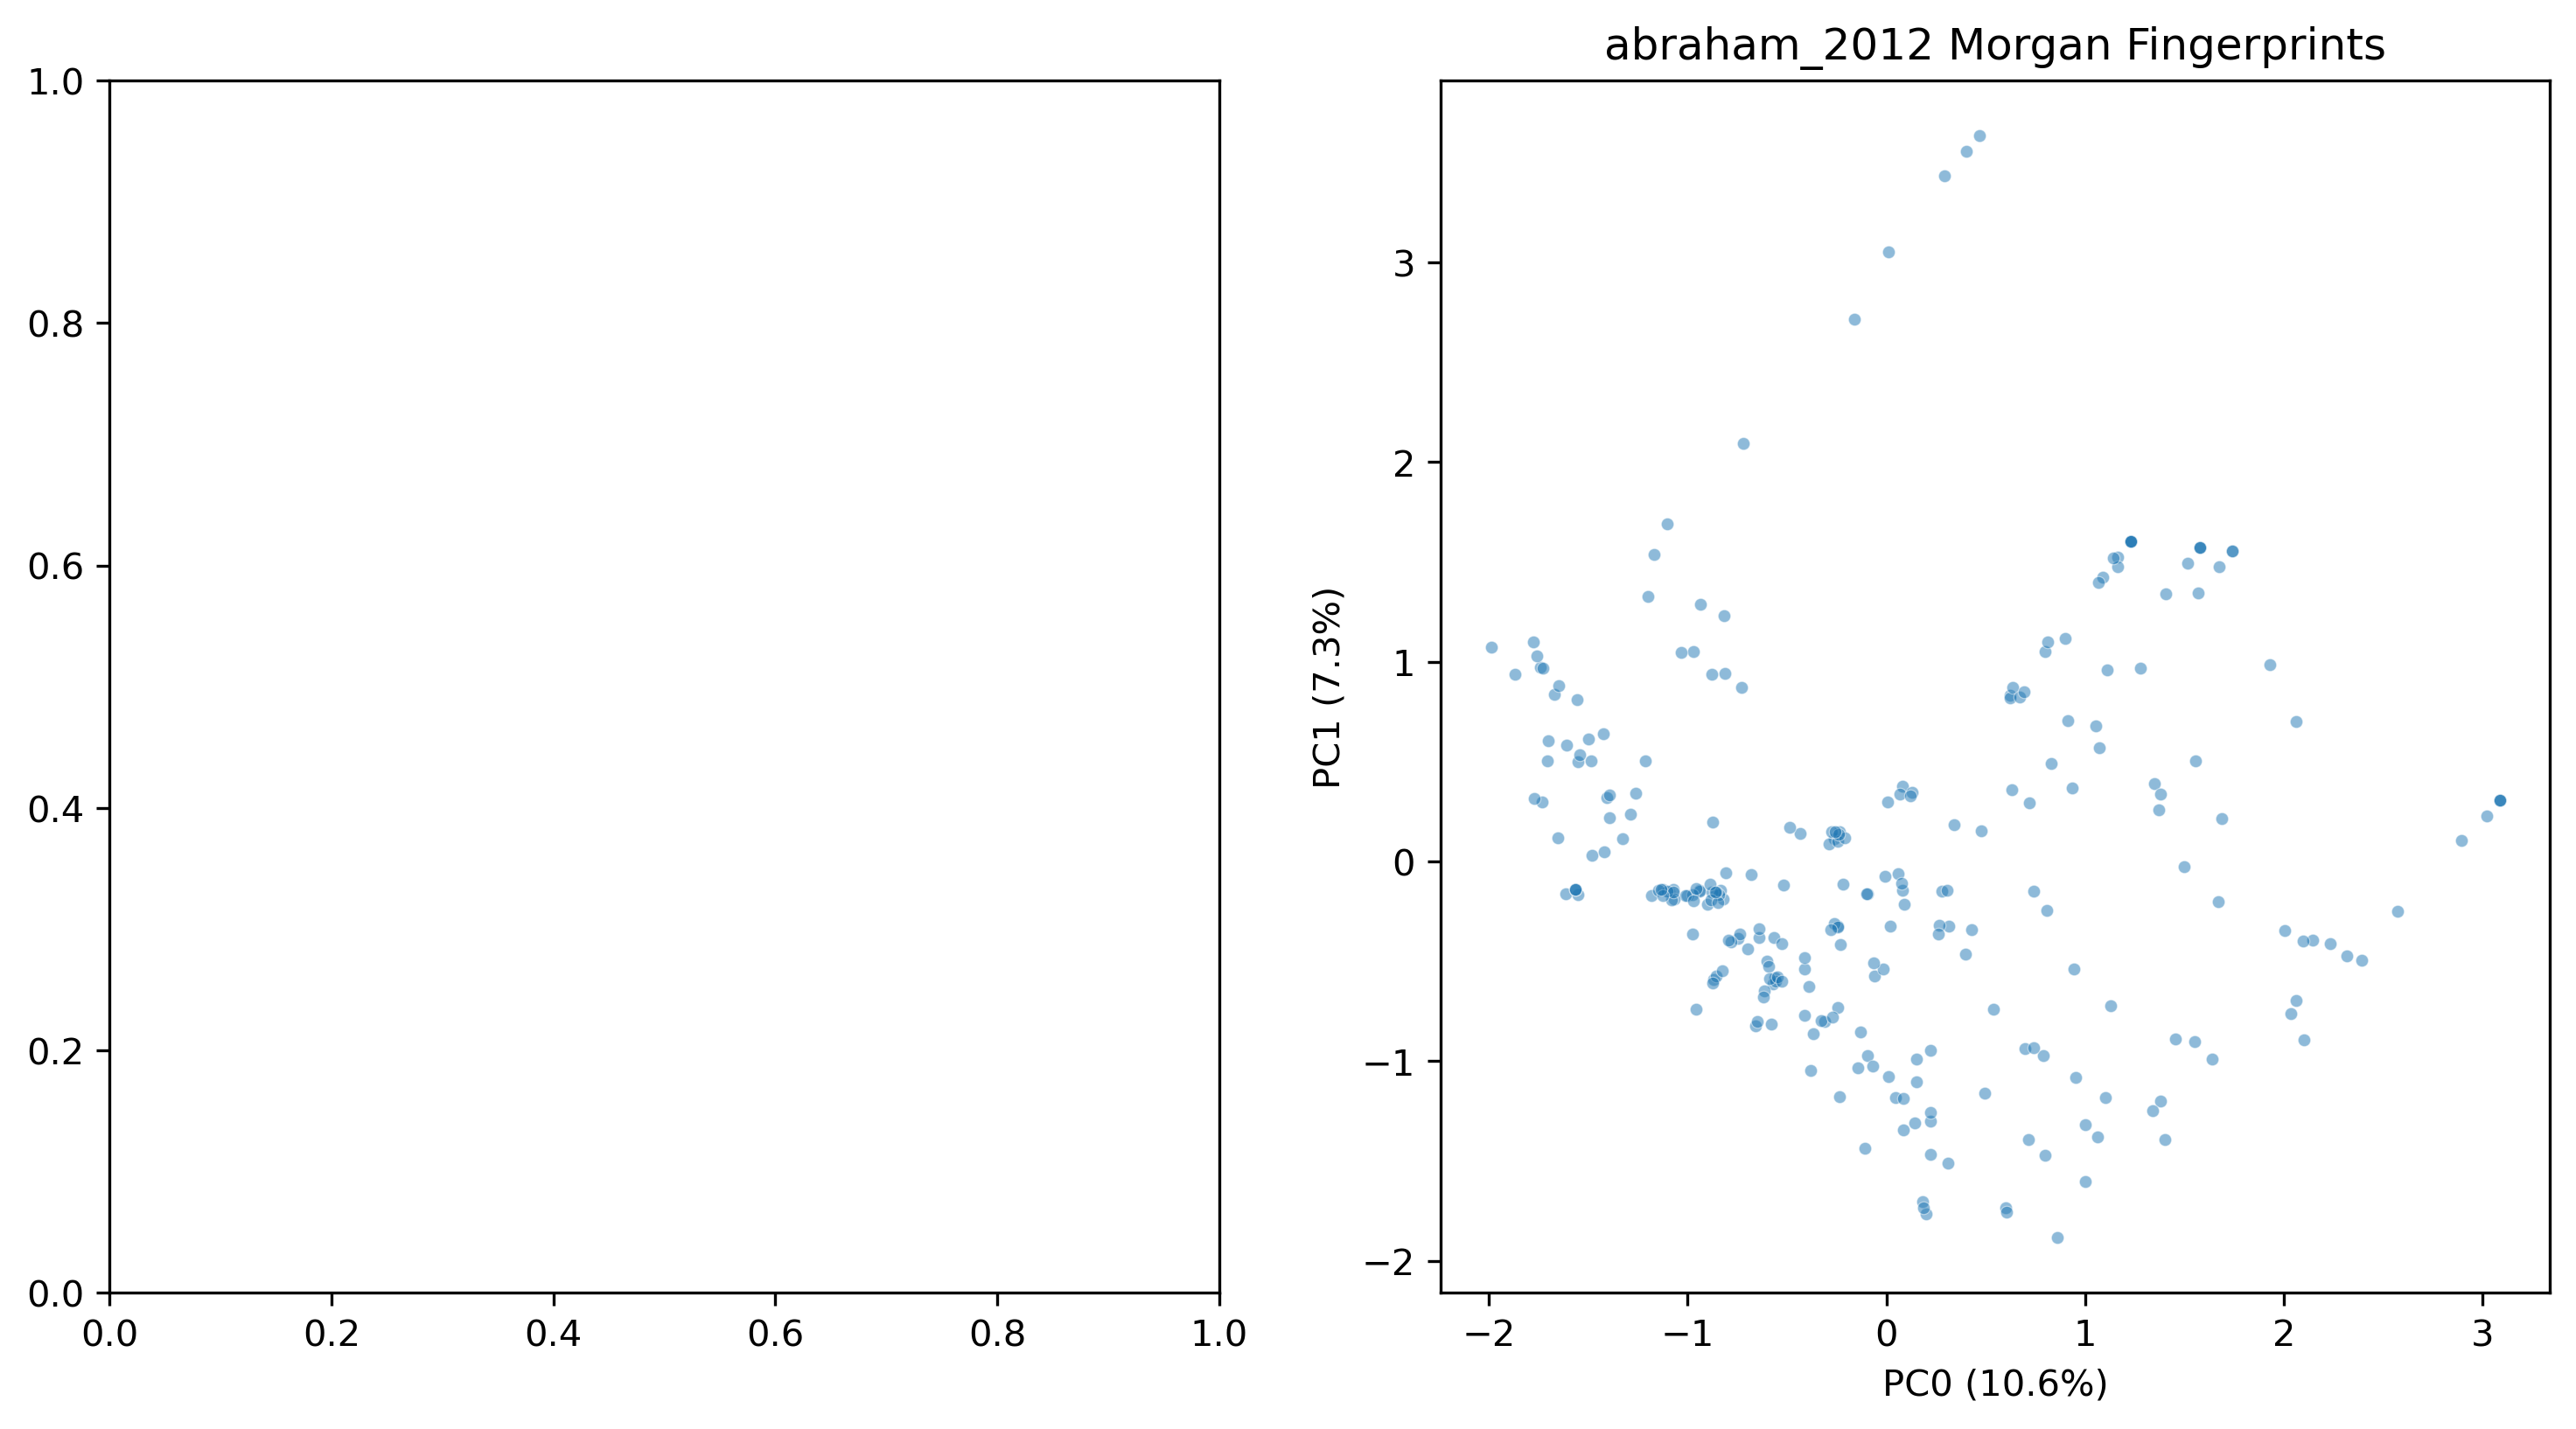

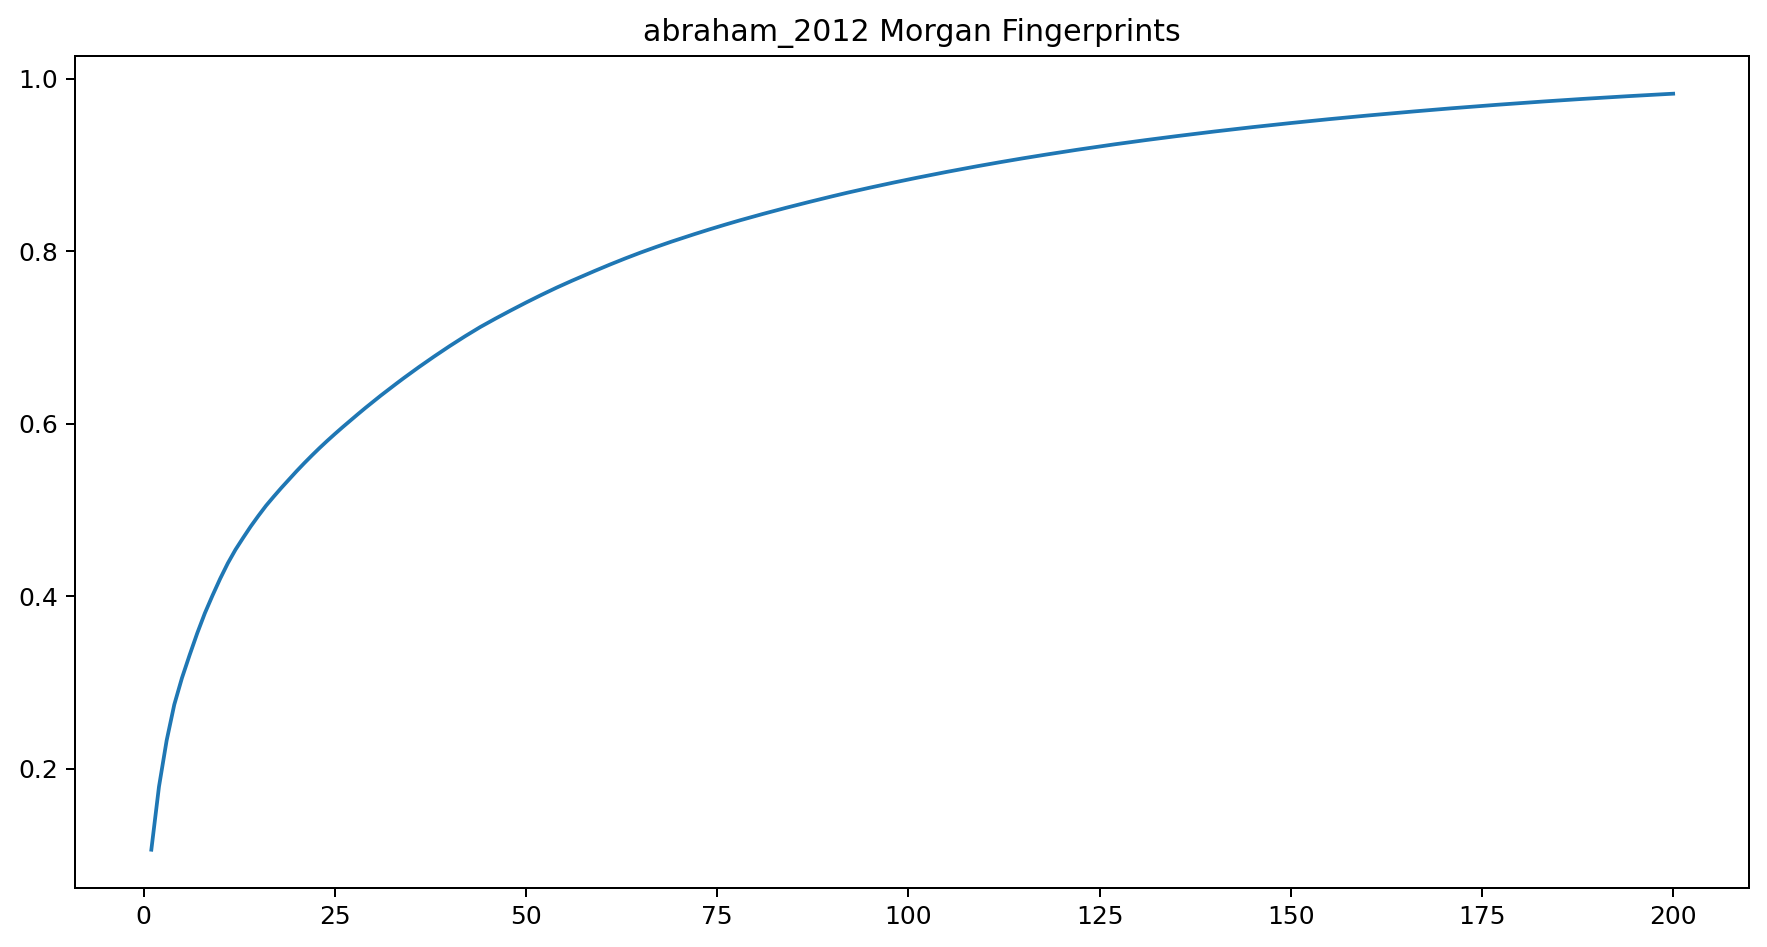

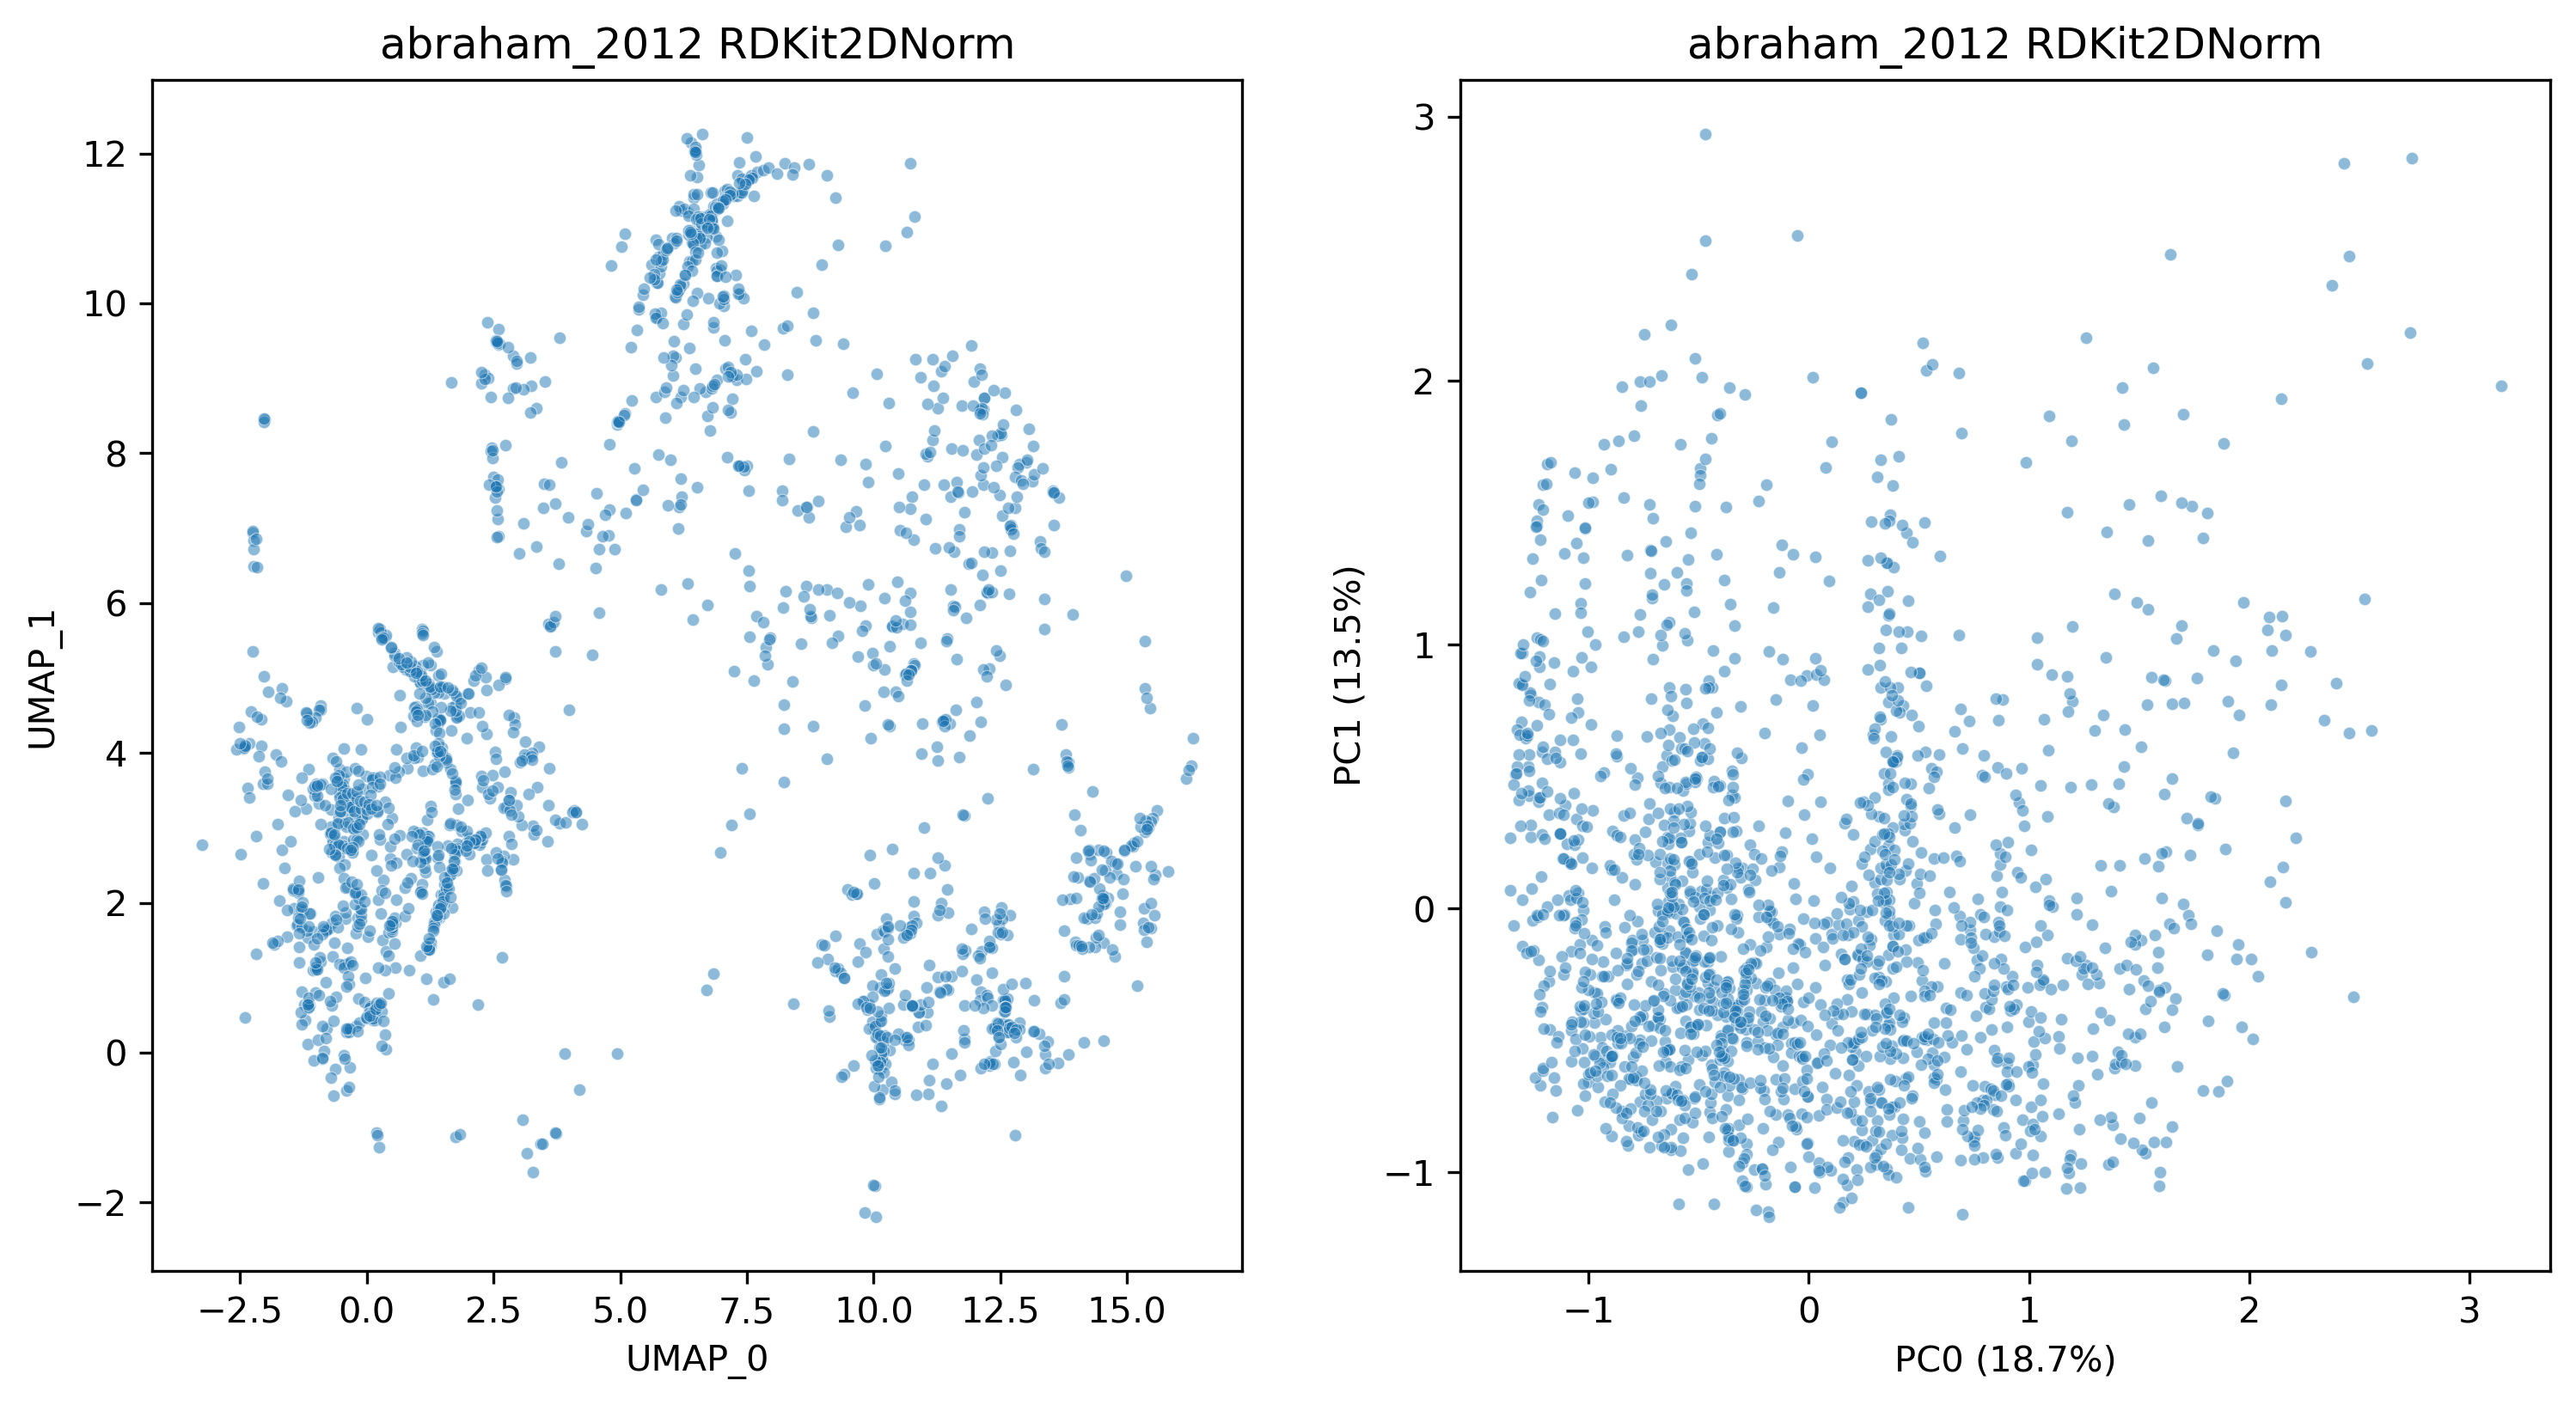

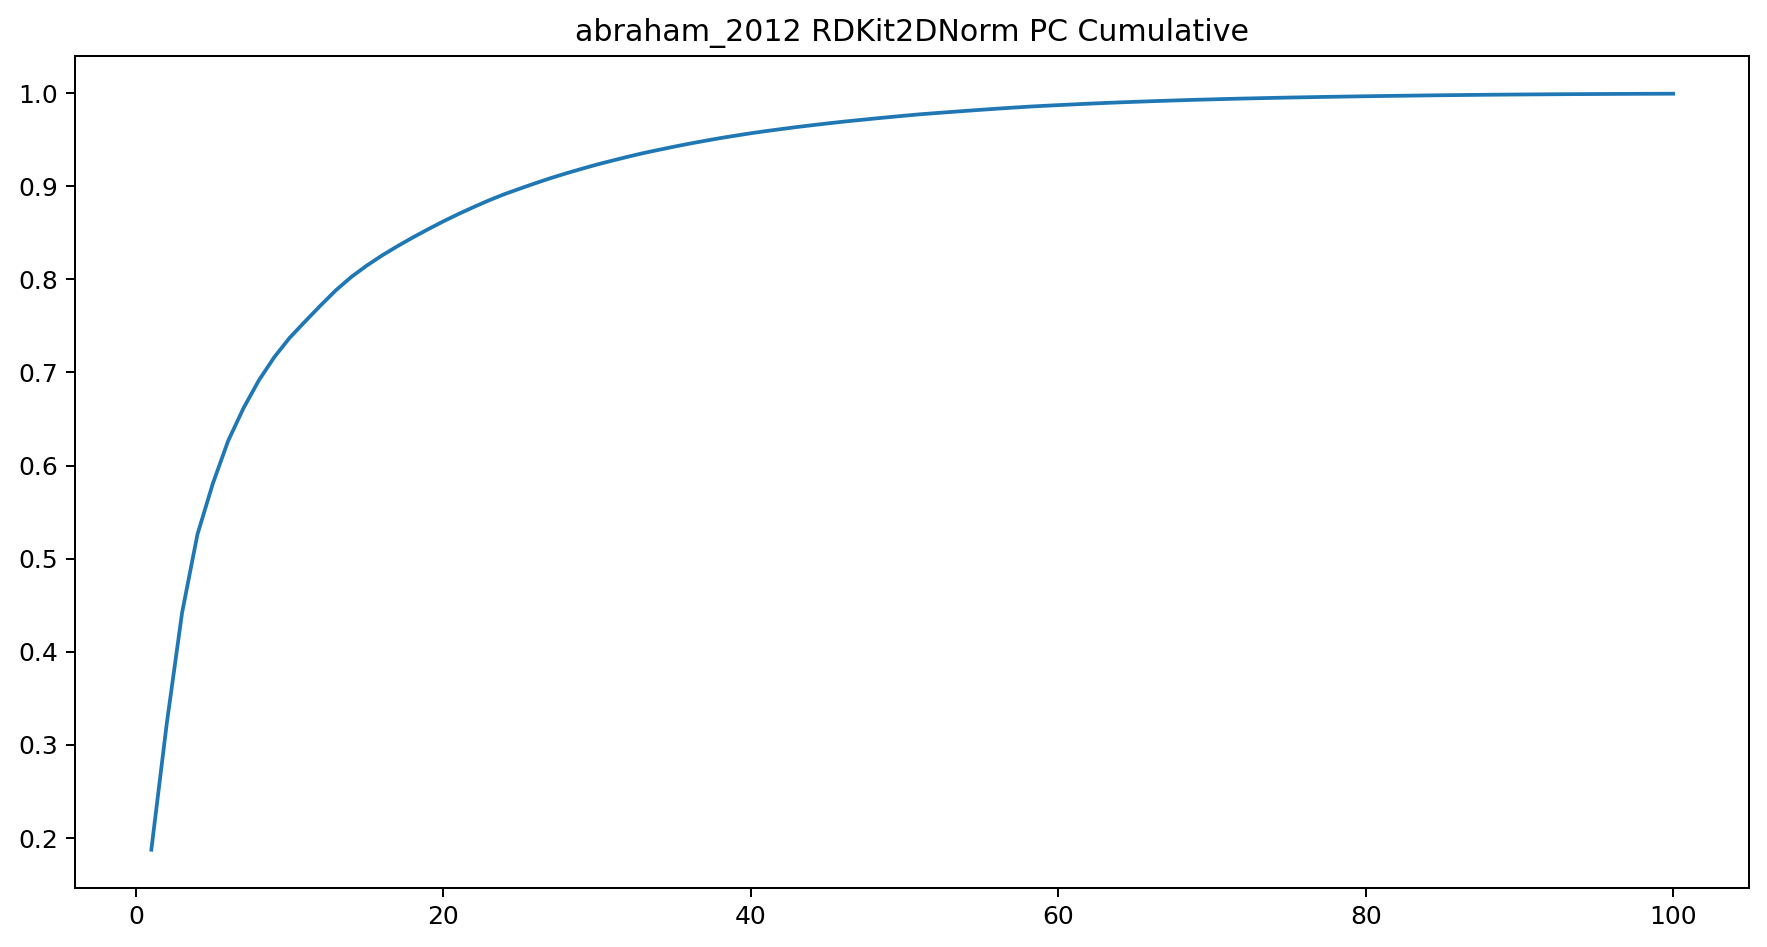

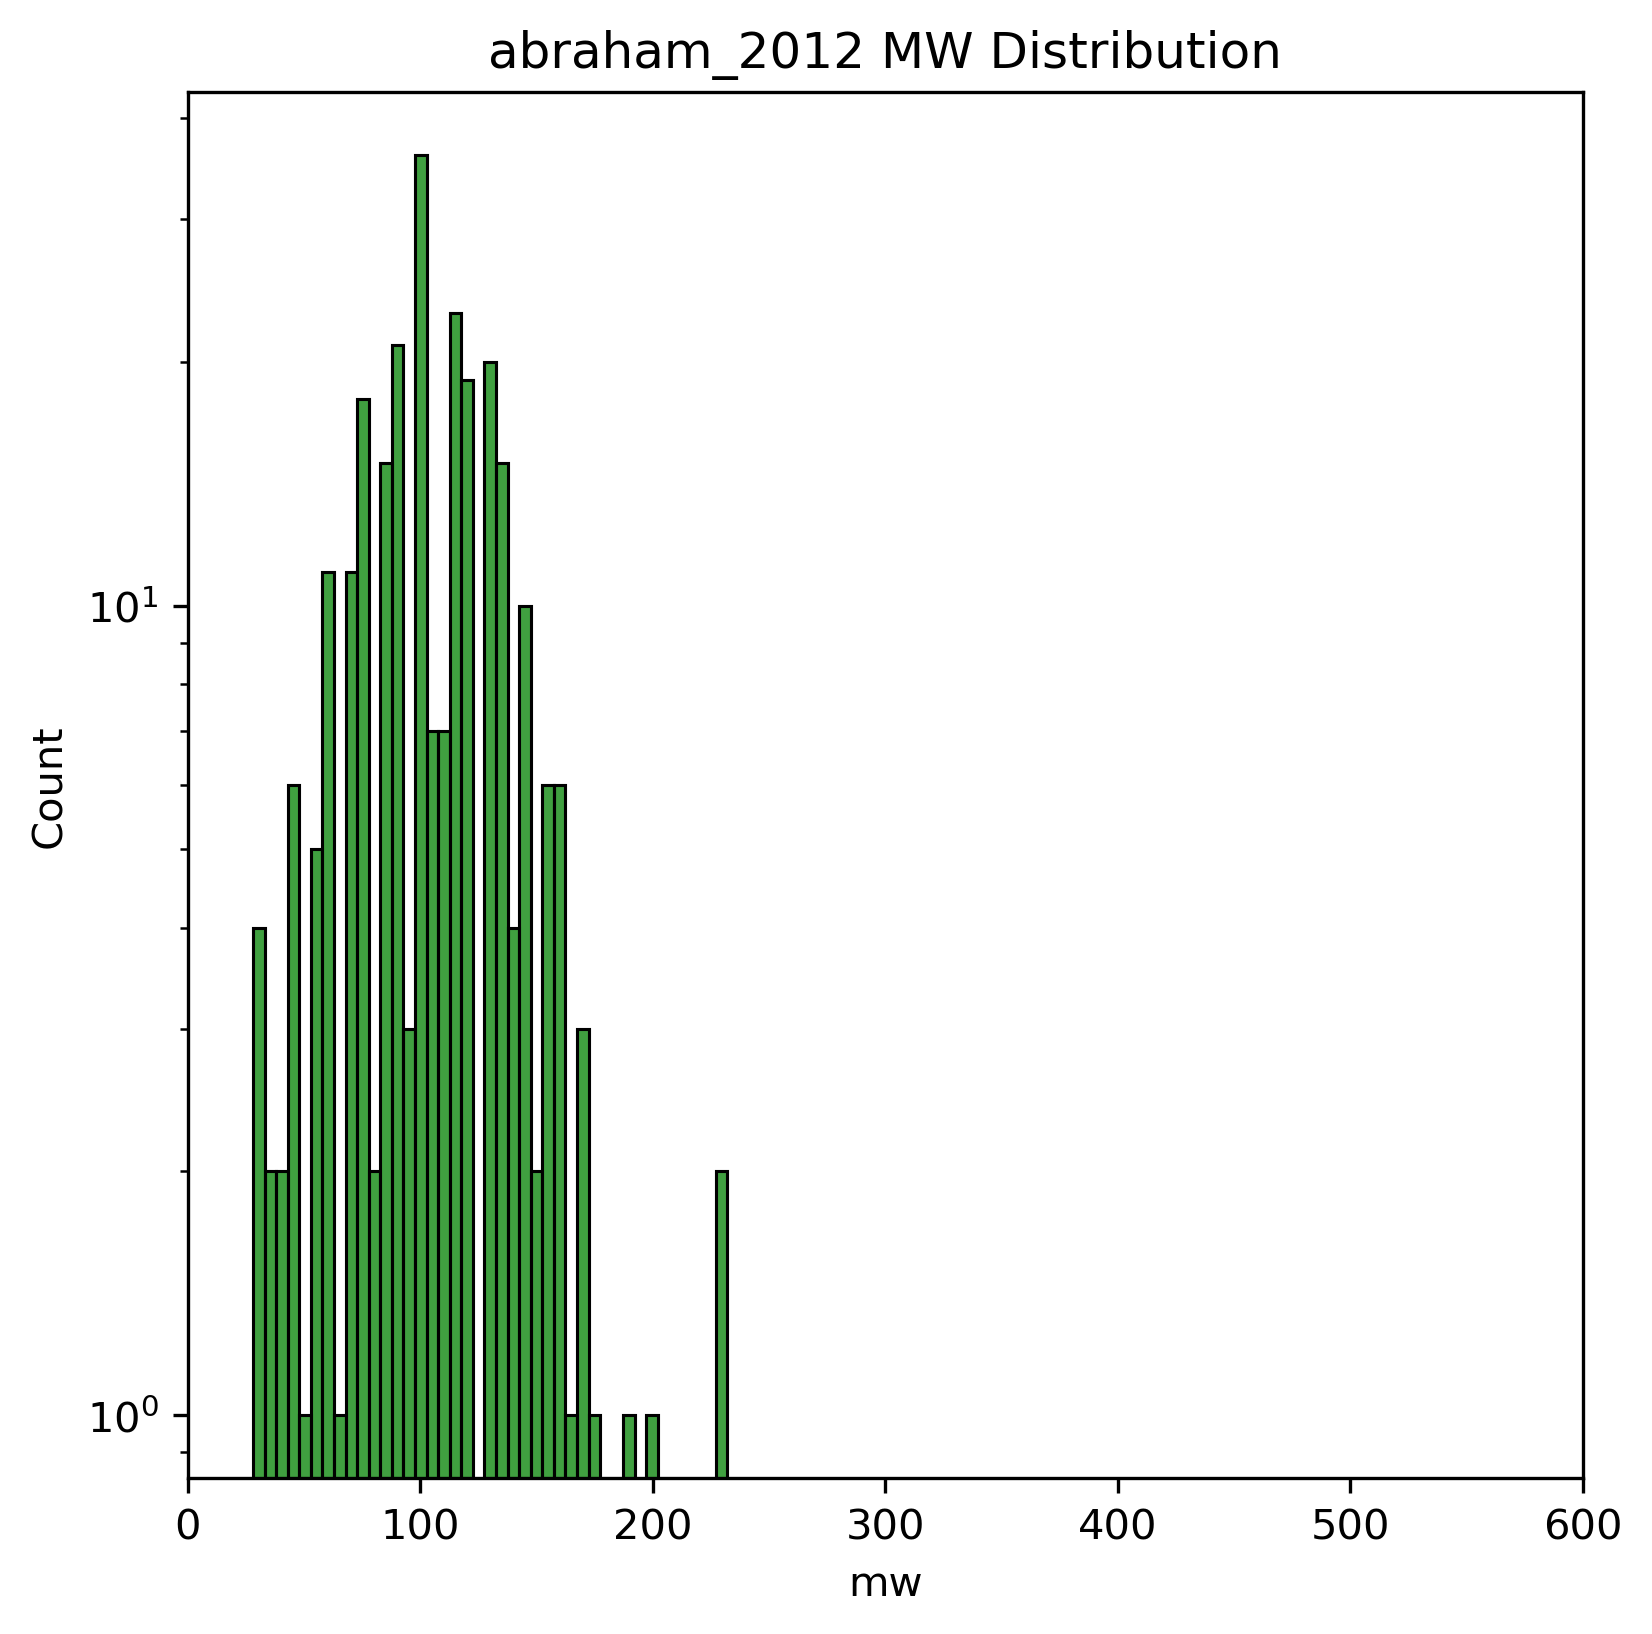

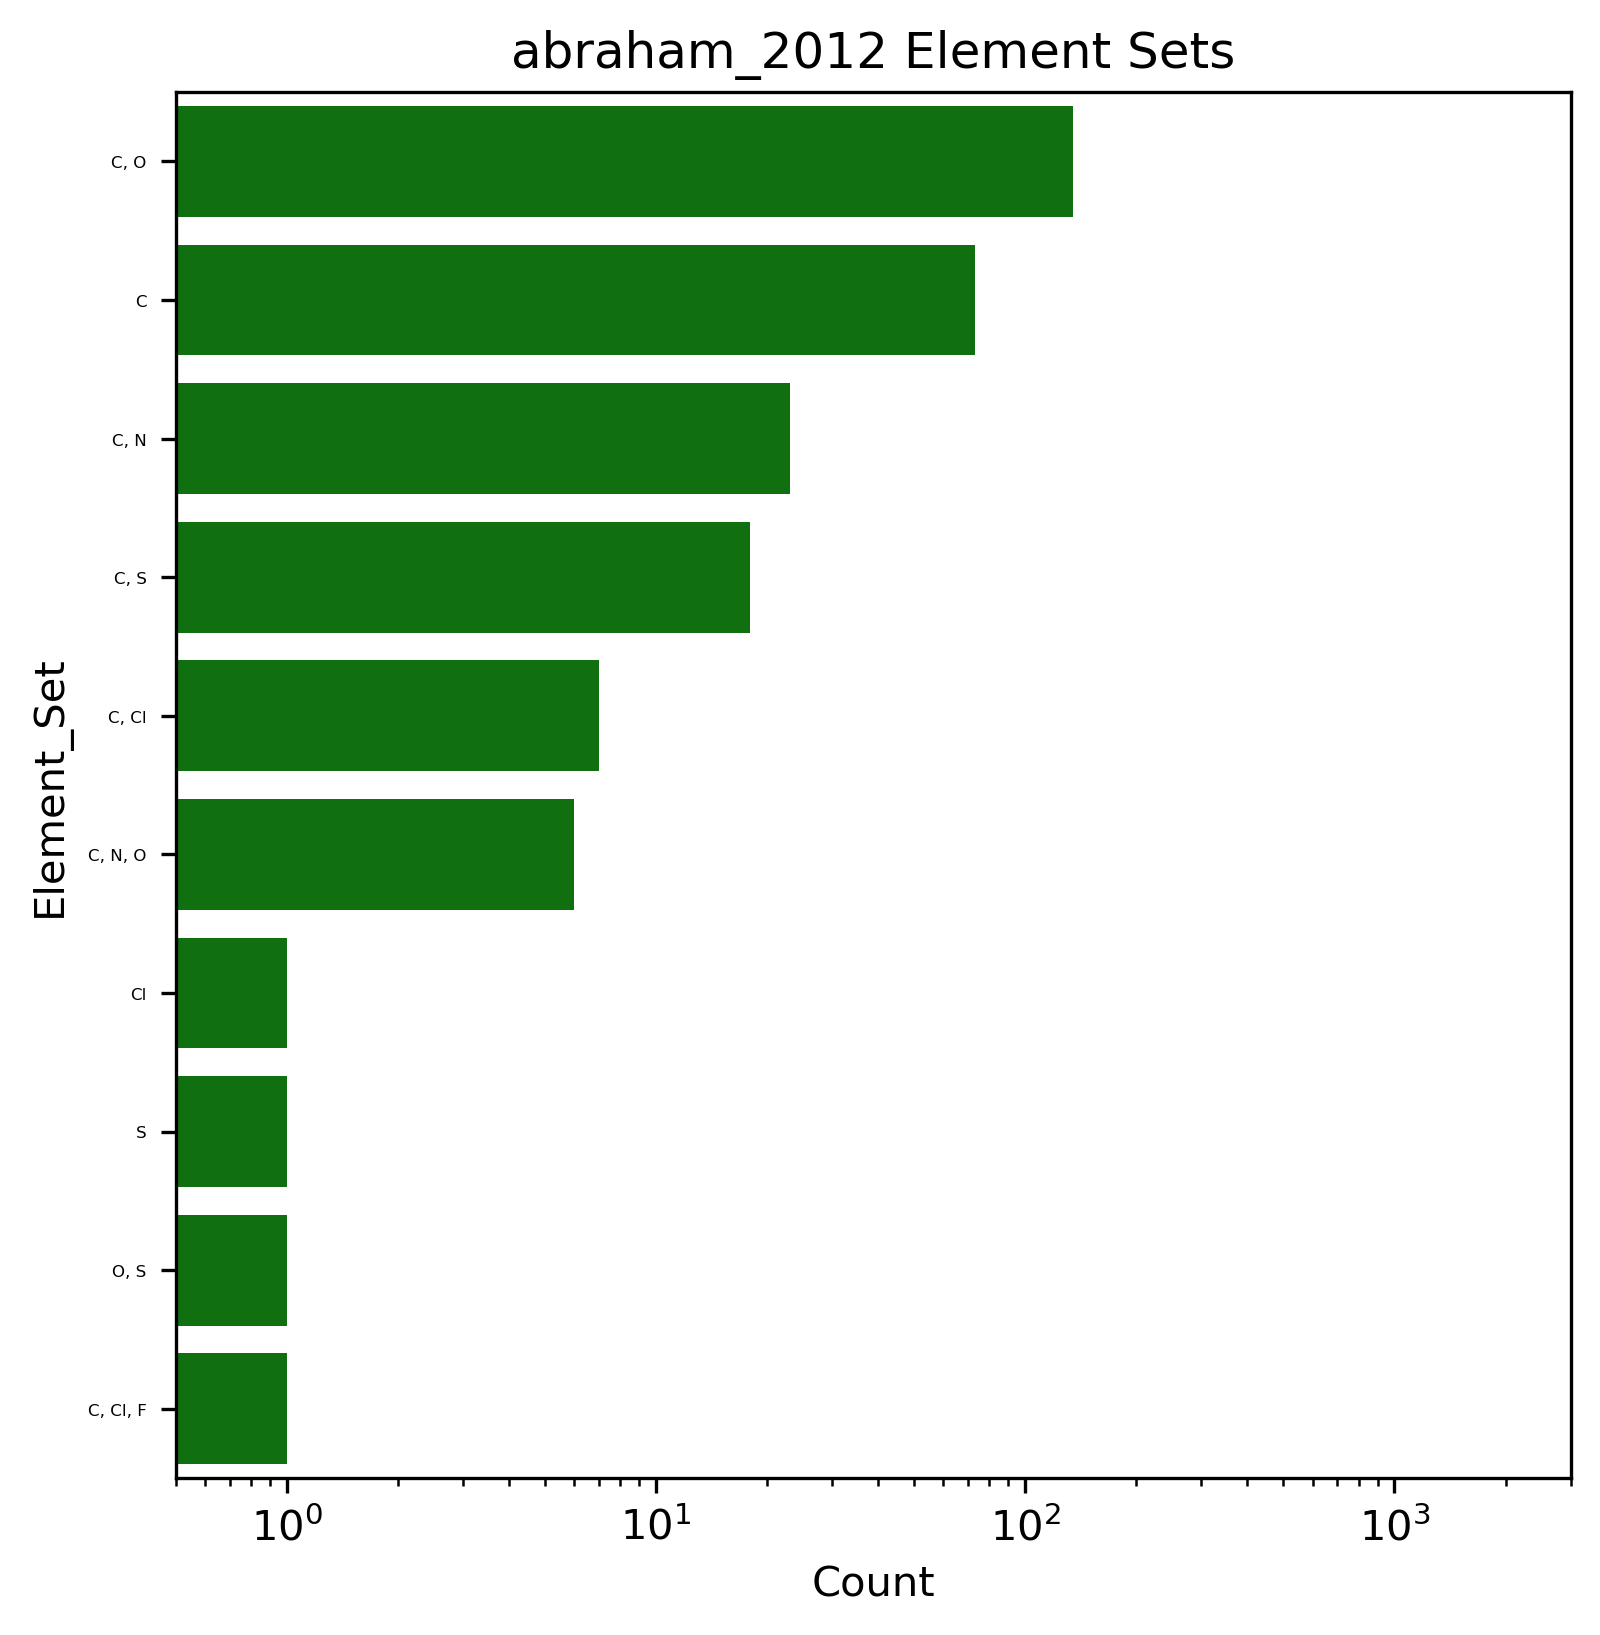

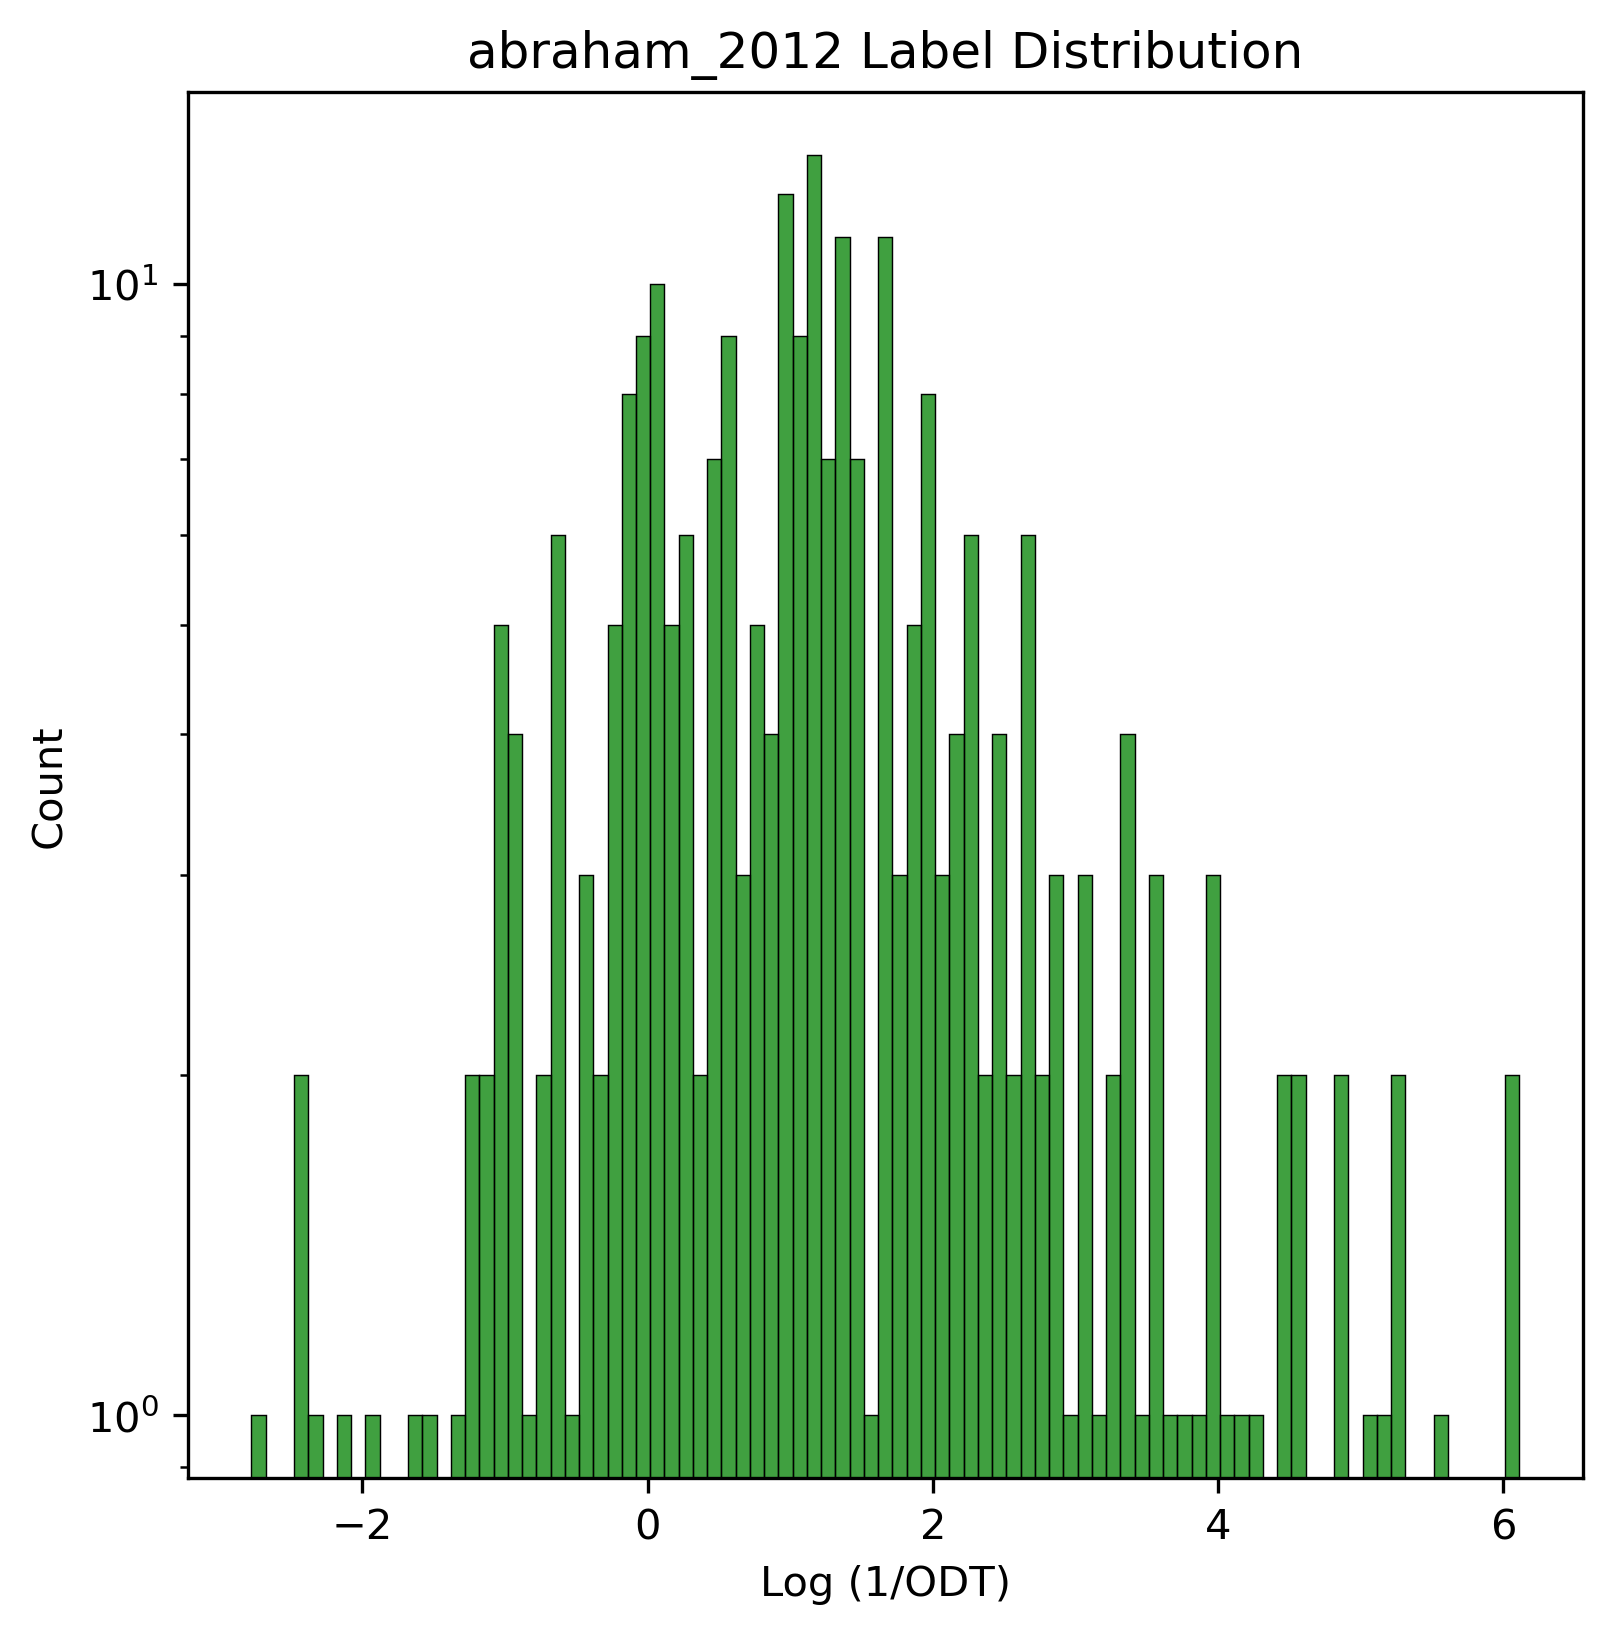

In [32]:
for _, dataset in file_df[file_df['dataset'] == 'abraham_2012'].iterrows():
#for _, dataset in file_df.iterrows():

    name = dataset['dataset']
    print(name)
    df = pd.read_csv(f'{name}/{name}_combined.csv')
    label_columns = literal_eval(dataset['new_label_columns'])
    columns = label_columns + ['IsomericSMILES']
    df = df[columns]


    df['rdkit'] = df.apply(lambda row: Chem.MolFromSmiles(row['IsomericSMILES']), axis=1)
    df['morgfp'] = df.apply(lambda row: GetMorganFingerprintAsBitVect(row['rdkit'], radius=3, nBits=2048), axis=1)
    df['fp'] = df.apply(lambda row: row['morgfp'].ToList(), axis=1)
    fig, ax = plt.subplots(1,2, figsize=(12,6), dpi=300)
    if dataset['dataset'] != 'abraham_2012':
        umap_model = umap.UMAP(metric = "jaccard",
                            densmap=True,
                            random_state=42,
                            low_memory = False)
        X_umap = umap_model.fit_transform(list(df['morgfp']))
        df["UMAP_0"], df["UMAP_1"] = X_umap[:,0], X_umap[:,1]

        #g = sns.scatterplot(x="UMAP_0", y="UMAP_1", data=df, ax=ax, hue='is_odor', s=12, alpha=0.5)
        g = sns.scatterplot(x="UMAP_0", y="UMAP_1", data=df, ax=ax[0], s=12, alpha=0.5)
        ax[0].set_title(f"{name} Morgan Fingerprints")

    pca = PCA(n_components=4)
    principalComponents = pca.fit_transform(df['fp'].to_list())
    #g = sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1], ax=ax, hue=df["is_odor"], s=12, alpha=0.5)
    g = sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1], ax=ax[1], s=12, alpha=0.5)
    ax[1].set_title(f"{name} Morgan Fingerprints")
    ax[1].set_xlabel(f"PC0 ({pca.explained_variance_ratio_[0]*100:.01f}%)")
    ax[1].set_ylabel(f"PC1 ({pca.explained_variance_ratio_[1]*100:.01f}%)")
    fig.savefig(f"{name}/{name}_01_morgan_fp.png", bbox_inches='tight')

    pca = PCA(n_components=200)
    principalComponents = pca.fit_transform(df['fp'].to_list())
    cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
    fig, ax = plt.subplots(1,1, figsize=(12,6), dpi=180)
    g = sns.lineplot(x=range(1,len(cumulative_variance_explained)+1), y=cumulative_variance_explained)
    ax.set_title(f"{name} Morgan Fingerprints")
    fig.savefig(f"{name}/{name}_02_morgan_pca_cumsum.png", bbox_inches='tight')

    df['chiral'] = df.apply(lambda row: is_chiral(row['rdkit']), axis=1)
    chiral_counts = df['chiral'].value_counts()
    print(f"Chiral counts: True: {chiral_counts.get(True, 0)}  False: {chiral_counts.get(False, 0)}")

    df['cistrans'] = df.apply(lambda row: check_cis_trans_isomerism(row['rdkit']), axis=1)
    cis_trans_counts = df['cistrans'].value_counts()
    print(f"Cistrans counts: True: {cis_trans_counts.get(True, 0)}  False: {cis_trans_counts.get(False, 0)}")

    if dataset['task'] == 'binary':
        df['is_odor_bool'] = df.apply(lambda row: bool(row[label_columns][0]), axis=1)
        odor_counts = df['is_odor_bool'].value_counts()
        print(f"Odor counts: True: {odor_counts.get(True, 0)}  False: {odor_counts.get(False, 0)}")       

    data = DreamLoader()
    data.load_benchmark("mayhew_2022")
    data.featurize("rdkit2d_normalized_features")
    dream_df = pd.DataFrame(data.features)

    umap_model = umap.UMAP(metric = "cosine",
                        densmap=True,
                        random_state=42,
                        low_memory = False)
    X_umap = umap_model.fit_transform(dream_df)
    dream_df["UMAP_0"], dream_df["UMAP_1"] = X_umap[:,0], X_umap[:,1]
    fig, ax = plt.subplots(1,2, figsize=(12,6), dpi=300)
    #g = sns.scatterplot(x="UMAP_0", y="UMAP_1", data=df, ax=ax, hue='is_odor', s=12, alpha=0.5)
    g = sns.scatterplot(x="UMAP_0", y="UMAP_1", data=dream_df, ax=ax[0], s=12, alpha=0.5)
    ax[0].set_title(f"{name} RDKit2DNorm")

    pca = PCA(n_components=4)
    principalComponents = pca.fit_transform(data.features)
    #g = sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1], ax=ax, hue=df["is_odor"], s=12, alpha=0.5)
    g = sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1], ax=ax[1], s=12, alpha=0.5)
    ax[1].set_title(f"{name} RDKit2DNorm")
    ax[1].set_xlabel(f"PC0 ({pca.explained_variance_ratio_[0]*100:.01f}%)")
    ax[1].set_ylabel(f"PC1 ({pca.explained_variance_ratio_[1]*100:.01f}%)")
    fig.savefig(f"{name}/{name}_03_rdkit2dnorm.png", bbox_inches='tight')

    pca = PCA(n_components=100)
    principalComponents = pca.fit_transform(data.features)
    cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
    fig, ax = plt.subplots(1,1, figsize=(12,6), dpi=180)
    g = sns.lineplot(x=range(1,len(cumulative_variance_explained)+1), y=cumulative_variance_explained)
    ax.set_title(f"{name} RDKit2DNorm PC Cumulative")
    fig.savefig(f"{name}/{name}_04_rdkit2dnorm_pca_cumsum.png", bbox_inches='tight')

    df['mw'] = df.apply(lambda row: ExactMolWt(row['rdkit']), axis=1)

    fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
    g = sns.histplot(df['mw'], ax=ax, binwidth=5, color='green')
    ax.set_title(f"{name} MW Distribution")
    ax.set_xlim([0,600])
    g.set_yscale("log")
    #ax.set_ylim([0, 100])
    fig.savefig(f"{name}/{name}_05_mw_dist.png", bbox_inches='tight')

    df['Element_Sets'] = df['IsomericSMILES'].apply(get_elements)

    # Create a Counter to count the occurrences of each set of elements
    element_set_counts = Counter(df['Element_Sets'])

    element_set_counts_df = pd.DataFrame(
        list(element_set_counts.items()), 
        columns=['Element_Set', 'Count']
    )

    # Convert tuple to string for better plotting
    element_set_counts_df['Element_Set'] = element_set_counts_df['Element_Set'].apply(lambda x: ', '.join(x))

    fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
    g = sns.barplot(data=element_set_counts_df.sort_values('Count', ascending=False), y='Element_Set', x='Count', color='green', ax=ax, orient="h")

    g.set_xscale("log")

    ax.set_title(f"{name} Element Sets")

    # Rotate the x-axis labels for better readability
    #plt.yticks(rotation=90, ha='center', size=6)
    plt.yticks(size=4)

    ax.set_xlim([0.5,3000])
    fig.savefig(f"{name}/{name}_06_element_sets.png", bbox_inches='tight')

    if dataset['task'] == 'multilabel':
        label_counts = df[label_columns].sum()
        count_df = label_counts.reset_index()
        count_df.columns = ['label', 'count']
        count_df.sort_values('count', ascending=False, inplace=True)
        fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
        g = sns.barplot(y='label', x='count', data=count_df, ax=ax, orient='h')
        plt.yticks(size=4)
        ax.set_xlim([1, 3000])
        g.set_xscale("log")
        fig.savefig(f"{name}/{name}_07_label_count.png", bbox_inches='tight')

        df['multilabelity'] = df[label_columns].sum(axis=1)
        fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
        g = sns.histplot(df['multilabelity'], ax=ax, binwidth=1, discrete=True)
        ax.set_title(f"{name} Multilabel")
        g.set_yscale("log")
        #ax.set_xticks(range(1,))
        fig.savefig(f"{name}/{name}_08_multilabelity.png", bbox_inches='tight')
    elif dataset['task'] == 'regression':
        if name == 'keller_2016':
            descriptors = ['Acid', 'Ammonia', 'Bakery', 'Burnt', 'Chemical', 'Cold', 'Decayed', 'Familiarity', 'Fish', 'Flower', 
                            'Fruit', 'Garlic', 'Grass', 'Intensity', 'Musky', 'Pleasantness', 'Sour', 'Spices', 'Sweaty', 'Sweet', 'Warm', 'Wood']
            metrics = ['mean', 'stdev', 'median', 'nonzeroproportion', 'nonzeromean', 'nonzerostdev']

            reshaped_df = pd.DataFrame(index=descriptors, columns=metrics)

            for descriptor in descriptors:
                for metric in metrics:
                    col_name = f"{descriptor}_{metric}"
                    if col_name in df.columns:
                        reshaped_df.loc[descriptor, metric] = df[col_name].iloc[0]

            # Convert to float and handle any remaining non-numeric values
            heatmap_data = reshaped_df.astype(float)

            # Create the heatmap
            fig, axes = plt.subplots(2, 3, figsize=(20, 15), dpi=300)
            fig.suptitle("Heatmaps of Descriptors and Metrics (Per-Metric Scaling)", fontsize=16)

            # Flatten the axes array for easy iteration
            axes = axes.flatten()

            # Create a heatmap for each metric
            for i, metric in enumerate(metrics):
                ax = axes[i]
                data = heatmap_data[[metric]].copy()
                
                # Create the heatmap
                sns.heatmap(data, ax=ax, cmap="viridis", annot=True, fmt=".6f", cbar_kws={'label': 'Value'})
                
                ax.set_title(f"{metric.capitalize()}")
                ax.set_xlabel("")
                if i % 3 == 0:  # Only show y-label for leftmost plots
                    ax.set_ylabel("Descriptors")
                else:
                    ax.set_ylabel("")

            plt.tight_layout()
            plt.savefig(f"{name}/{name}_09_keller_heatmap.png", bbox_inches='tight')
            plt.show()
        else:
            fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
            g = sns.histplot(df[label_columns[0]], ax=ax, binwidth=0.1, color='green')
            ax.set_title(f"{name} Label Distribution")
            g.set_yscale("log")
            fig.savefig(f"{name}/{name}_09_regression.png", bbox_inches='tight')